# Google Analytics 4 (GA4) Data in Pyton Using run_report 

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange
from google.analytics.data_v1beta.types import Dimension
from google.analytics.data_v1beta.types import Metric
from google.analytics.data_v1beta.types import RunReportRequest
from google.analytics.data_v1beta.types import OrderBy

In [3]:
## Set up global variables

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'google_analytics_api_access_keys.json'
property_id = 'GA4_property_id'

client = BetaAnalyticsDataClient()

In [4]:
## Format Report - run_report method
def format_report(request):
    response = client.run_report(request)
    
    # Row index
    row_index_names = [header.name for header in response.dimension_headers]
    row_header = []
    for i in range(len(row_index_names)):
        row_header.append([row.dimension_values[i].value for row in response.rows])

    row_index_named = pd.MultiIndex.from_arrays(np.array(row_header), names = np.array(row_index_names))
    # Row flat data
    metric_names = [header.name for header in response.metric_headers]
    data_values = []
    for i in range(len(metric_names)):
        data_values.append([row.metric_values[i].value for row in response.rows])

    output = pd.DataFrame(data = np.transpose(np.array(data_values, dtype = 'f')), 
                          index = row_index_named, columns = metric_names)
    return output

In [5]:
request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="month"), 
                    Dimension(name="sessionMedium")],
        metrics=[Metric(name="averageSessionDuration"), 
                 Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'month'}),
                    OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
        date_ranges=[DateRange(start_date="2022-06-01", end_date="today")],
    )

request

property: "properties/314230899"
dimensions {
  name: "month"
}
dimensions {
  name: "sessionMedium"
}
metrics {
  name: "averageSessionDuration"
}
metrics {
  name: "activeUsers"
}
date_ranges {
  start_date: "2022-06-01"
  end_date: "today"
}
order_bys {
  dimension {
    dimension_name: "month"
  }
}
order_bys {
  dimension {
    dimension_name: "sessionMedium"
  }
}

In [6]:
format_report(request)

averageSessionDuration  activeUsers
month sessionMedium                                     
06    (none)                     223.054718        149.0
      (not set)                  712.812134          3.0
      organic                    181.314072       1087.0
      referral                   265.759521         20.0
07    (none)                     119.074570        130.0
      (not set)                  177.200439         10.0
      organic                    188.490265       1080.0
      referral                    11.143864         17.0
08    (none)                     120.936272        130.0
      (not set)                    7.915614          3.0
      organic                    192.588272       1110.0
      referral                   131.209595         35.0
09    (none)                     107.333832        132.0
      (not set)                  326.795990          8.0
      organic                    182.045670       1264.0
      referral                   344.347870         27.0
10    (none)                      95.990707         26.0
      (not set)                    0.000000          1.0
      organic                    186.618057        397.0
      referral                   129.545151          7.0

In [7]:
output_df = format_report(request)

## Export to Excel
output_df.reset_index().to_excel('GA4_python_output.xlsx', sheet_name = 'GA4_report', engine = 'xlsxwriter')

In [8]:
## Export to CSV
output_df.to_csv('GA4_python_output.csv')

# GA4 Monthly Traffic Chart

In [9]:
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
monhtly_users_pivot = pd.pivot_table(output_df, 
                                     columns=['sessionMedium'], 
                                     index=['month'], 
                                     values=['activeUsers'], 
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)

In [11]:
monhtly_users_pivot

sessionMedium,(none),(not set),organic,referral
month,,,,
06,149,3,1087,20
07,130,10,1080,17
08,130,3,1110,35
09,132,8,1264,27
10,26,1,397,7


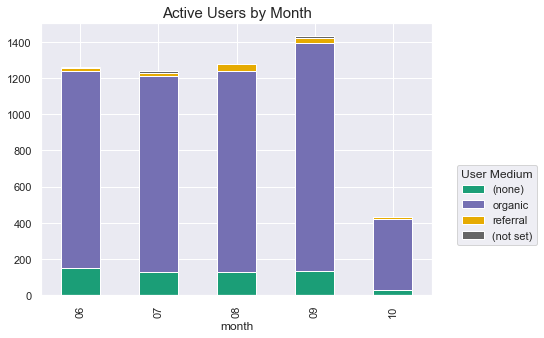

In [12]:
sns.set_theme()
monhtly_users_pivot.plot.bar(y = ['(none)', 'organic', 'referral', '(not set)'], stacked = True,
                             colormap = 'Dark2',
                             figsize=(7,5), title = 'Active Users by Month')
plt.legend(title = 'User Medium', bbox_to_anchor = (1.05, 0.5))
plt.title('Active Users by Month', fontsize = 15);

# GA4 Traffic Report

In [13]:
## Global variables
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'google_analytics_api_access_keys.json'
property_id = 'GA4_property_id'
client = BetaAnalyticsDataClient()

## Report dates
end_date = 'today' ## ("today" or "yyyy-mm-dd")
no_days = 90

In [14]:
def calc_start_date(end_date, no_days):
    if end_date == "today":
        start_date = date.today() - timedelta(days=no_days)
    else:
        start_date = date.fromisoformat(end_date) - timedelta(days=no_days)
        
    return start_date.strftime("%Y-%m-%d") 

def produce_report (end_date, no_days, property_id = property_id, client = client):
    daily_traffic_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="date"), 
                        Dimension(name="sessionMedium")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(dimension = {'dimension_name': 'date'}),
                        OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )
    
    page_users_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="pagePath")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(metric = {'metric_name': 'activeUsers'}, desc = True)],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )
    
    
    landing_page_users_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="landingPage")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(metric = {'metric_name': 'activeUsers'}, desc = True)],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )

    daily_traffic = format_report(daily_traffic_request).reset_index()
    active_users_pivot = pd.pivot_table(daily_traffic, 
                                     columns=['sessionMedium'], 
                                     index=['date'], 
                                     values=['activeUsers'], 
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)
    active_users_pivot.index = active_users_pivot.index.str.slice(start=4)
    
    # Produce pie and line charts
    
    fig, (axs1, axs2) = plt.subplots(1,2, figsize = (14, 4), gridspec_kw={'width_ratios': [1, 2]})
    pie_data = daily_traffic.groupby(by = ['sessionMedium']).sum().sort_values(by = ['activeUsers'], ascending = False)
    pie_data.plot.pie(ax = axs1,
                      colormap = 'Dark2',
                      y = ['activeUsers'],
                      title = 'Active Users by Medium',
                      legend = False, 
                      label = False,
                      startangle = 0, 
                      autopct = lambda p:f'{p:.0f}%').set_ylabel('')
    
    active_users_pivot.plot.line(ax = axs2, 
                                 colormap = 'Dark2',
                                 y = pie_data.index, 
                                 title = 'Active Users by Day')


    axs2.legend(title = 'User Medium', bbox_to_anchor = (1.05, 0.6))

    plt.show();
    
    # Produce Top 10 pgaes output tables
    landing_table = format_report(landing_page_users_request)
    landing_table['activeUsers'] = landing_table['activeUsers'].astype('int') 
    page_users_table = format_report(page_users_request)
    page_users_table['activeUsers'] = page_users_table['activeUsers'].astype('int') 
    
    print('\nTop 10 Landing Pages')
    display(landing_table[0:10])
    print('\nTop 10 Visited Pages')
    display(page_users_table[0:10])

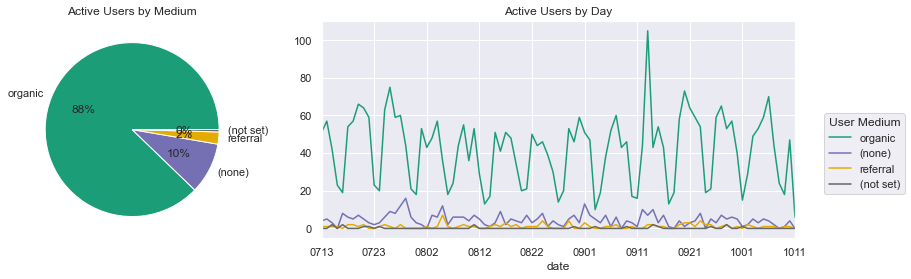


Top 10 Landing Pages


,activeUsers
landingPage,
/churn-analysis-in-excel-telecom-example/,801
(not set),705
/control-holdout-group-sample-size-calculation/,533
/a-guide-to-scientific-a-b-testing/,451
/churn-analysis-ultimate-guide-to-customer-attrition/,389
/nlp-with-aws-comprehend-how-to-guide/,330
/propensity-to-churn-modeling-does-not-help-reduce-churn/,315
/universal-control-groups-and-advanced-experiments-in-marketing/,220
/descriptive-predictive-prescriptive-analytics-in-marketing/,217



Top 10 Visited Pages


,activeUsers
pagePath,
/churn-analysis-in-excel-telecom-example/,817
/control-holdout-group-sample-size-calculation/,564
/a-guide-to-scientific-a-b-testing/,475
/churn-analysis-ultimate-guide-to-customer-attrition/,464
/propensity-to-churn-modeling-does-not-help-reduce-churn/,335
/nlp-with-aws-comprehend-how-to-guide/,330
/universal-control-groups-and-advanced-experiments-in-marketing/,238
/descriptive-predictive-prescriptive-analytics-in-marketing/,229
/review-of-graduate-certificate-in-data-science-from-harvard/,181


In [15]:
produce_report(end_date, no_days)